Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

Filename identifiers 

1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
2. Vocal channel (01 = speech, 02 = song).
3. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
4. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
5. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
6. Repetition (01 = 1st repetition, 02 = 2nd repetition).
7. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [1]:
emotion_dict = {'01' : 'neutral', 
                  '02' : 'calm', 
                  '03' : 'happy', 
                  '04' : 'sad', 
                  '05' : 'angry', 
                  '06' : 'fearful', 
                  '07' : 'disgust', 
                  '08' : 'surprised', 
                 }
                 
def get_label(filename):
  codes = filename.split('-')
  emotion_code = codes[2]
  emotion_label = emotion_dict[emotion_code]
  return emotion_label

print( get_label("03-02-03-02-02-02-02.wav") )
print( get_label("03-02-05-02-02-02-02.wav") )

happy
angry


In [2]:
import json
import os
import math
import librosa

data_path = "/content/drive/MyDrive/Colab Notebooks/Zenodo_1188976"
json_path = "/content/drive/MyDrive/Colab Notebooks/SpeechEmotionMFCC.json"

SAMPLE_RATE = 22050 #bit per second

def save_mfcc(data_path, json_path, num_coef=13, size_ftt=2048, size_hop=512):
  data = {
          "labels": [],
          "mfcc": []
         }
  
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):
    if dirpath is not data_path:
      for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        soundwave, sampleRate = librosa.load(file_path, sr=SAMPLE_RATE)

        label = get_label(filename)

        mfcc = librosa.feature.mfcc(soundwave, sr=sampleRate, n_fft=size_ftt, n_mfcc=num_coef, hop_length=size_hop)
        mfcc = mfcc.T

        data["labels"].append(label)
        data["mfcc"].append(mfcc.tolist())
  
  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)

#save_mfcc(data_path, json_path) #It takes about 15 minutes

In [3]:
import numpy as np

label_dict = {'neutral' : 0, 
              'calm' : 1, 
              'happy' : 2, 
              'sad' : 3, 
              'angry' : 4, 
              'fearful' : 5, 
              'disgust' : 6, 
              'surprised' : 7, 
              }

def load_data(json_path):

    with open(json_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    mfccs = np.array(data["mfcc"])
    labels = np.asarray(data["labels"])

    print("Data succesfully loaded!")

    x = np.zeros((mfccs.shape[0], 150, 13))
    y = np.zeros(labels.shape[0])
    for i in range(len(mfccs)):
      mfcc = np.array(mfccs[i])
      label = labels[i]
      x[i] = np.resize(mfcc, (150,13))
      y[i] = label_dict[label]

    return x, y

x, y = load_data(json_path)
print(x.shape)
print(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Data succesfully loaded!
(1440, 150, 13)
[3. 0. 1. ... 6. 7. 7.]


In [10]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Model 
model = keras.Sequential()

model.add(keras.layers.LSTM(128, input_shape=(x.shape[1], x.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(128))

model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(8, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=25)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 150, 128)          72704     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)               

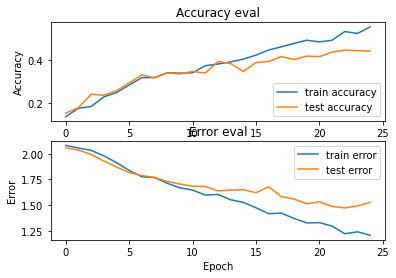

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)

axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()

In [6]:
import tensorflow as tf

predictions = model.predict(x_test)
print(predictions[0])

[0.03873065 0.03306264 0.02731846 0.03210729 0.52891105 0.12719695
 0.15703267 0.05564025]
